### Multi-omic Dataset: Latent representation using Autoencoders
- Load Data
- Normalize Data
- Define Autoencoder Model
- Train Autoencoder with normalized dataset
- Use transformed dataset for classification
- Use transformed dataset for clustering
- Evaluation and Conclusions

In [4]:
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_renal_data.iloc[:,1:],y_renal_data["label"],test_size=0.2, random_state=1) # Drop the Donor ID column from both datasets

# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

# We will use "X_train_norm" as training dataset for the Autoencoder

In [20]:
## AUTOENCODER MODEL
# Define the model using the keras functional API
def build_autoencoder(encoding_dim: int, number_features: int, regularizer: tf.keras.regularizers.Regularizer, dropout: float):
    """Two-input autoencoder build function
       Parameters: encoding_dim: Size of the latent space (bottleneck layer size).
                   number_features: Tuple with the sizes of the two inputs.
                   regularizer: keras regularizer object
       Returns the 3 models: full autoencoder, the encoder part and the decoder part
    """
    if dropout > 1:
        dropout = 1
    elif dropout < 0:
        dropout = 0
    # this is the reduction of our encoded representations, in times.
    print(f"Compression: {number_features/encoding_dim}")

    first_layer_size = number_features/40
    second_layer_size = number_features/120
    
    ## ENCODER
    # encoder first input placeholder.
    first_input = layers.Input(shape=(number_features))
    # encoder first Hidden Layer - H1
    H1 = layers.Dense(first_layer_size, activation='relu', kernel_regularizer=regularizer)(first_input)
    # encoder first Dropout Layer - D1
    D1 = layers.Dropout(dropout)(H1)
    # encoder first Batch Normalization Layer - BN1
    BN1 = layers.BatchNormalization()(D1)
    # encoder second Hidden Layer - H2
    H2 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN1)
    # encoder second Dropout Layer - D2
    D2 = layers.Dropout(dropout)(H2)
    # encoder first path second Batch Normalization Layer - BN2
    BN2 = layers.BatchNormalization()(D2)

   
    ## BOTTLENECK 
    bottleneck = layers.Dense(encoding_dim, activation='relu', kernel_regularizer=regularizer)(BN2)

    # this model maps an input to its encoded representation
    encoder = keras.models.Model(first_input, bottleneck, name='encoder')

    ## DECODER
    # Decoder Input Layer - Encoding dimension
    encoded_input = layers.Input(shape=(encoding_dim,))
    # decoder first Dropout Layer - D3
    D3 = layers.Dropout(dropout)(encoded_input)
    # decoder first Batch Normalization Layer - BN3 
    BN3 = layers.BatchNormalization()(D3)
    # decoder first Hidden Layer - H3
    H3 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN3)
    # decoder second Dropout Layer - D4
    D4 = layers.Dropout(dropout)(H3)
    # decoder second Batch Normalization Layer - BN4 
    BN4 = layers.BatchNormalization()(D4)
    # decoder reconstruction layer - O1
    O1 = layers.Dense(number_features, activation='sigmoid')(BN4)

    # create the decoder model
    decoder = keras.models.Model(encoded_input, O1)

    # create the full autoencoder
    encoder_model = encoder(first_input)
    decoder_model = decoder(encoder_model)

    autoencoder = keras.models.Model(first_input, decoder_model, name="autoencoder")
    
    return autoencoder, encoder, decoder

# Set Optimizer: Adam with learning rate=0.001
optimizer = tf.keras.optimizers.Adam(0.001)
# Set Early Stop Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)

## Call autoencoder build function and get the AE, the encoder and the decoder.
autoencoder, encoder, decoder = build_autoencoder(encoding_dim=20, number_features=X_train_norm.shape[1], regularizer=tf.keras.regularizers.l1_l2(0.0001,0), dropout=0.5)
# Compile the autoencoder using Mean Square Error loss function.
autoencoder.compile(optimizer=optimizer,
                        loss="mse",
                        metrics=['mse'])


Compression: 1025.1


Train on 433 samples, validate on 109 samples
Epoch 1/100
433/433 [==============================] - 4s 10ms/sample - loss: 0.5401 - mse: 0.0156 - val_loss: 0.5858 - val_mse: 0.0581
Epoch 2/100
433/433 [==============================] - 4s 9ms/sample - loss: 0.5828 - mse: 0.0161 - val_loss: 0.6273 - val_mse: 0.0561
Epoch 3/100
433/433 [==============================] - 4s 9ms/sample - loss: 0.5345 - mse: 0.0149 - val_loss: 0.4978 - val_mse: 0.0587
Epoch 4/100
433/433 [==============================] - 4s 10ms/sample - loss: 0.4817 - mse: 0.0148 - val_loss: 0.5164 - val_mse: 0.0577
Epoch 5/100
433/433 [==============================] - 4s 10ms/sample - loss: 0.4764 - mse: 0.0142 - val_loss: 0.5032 - val_mse: 0.0566
Epoch 6/100
433/433 [==============================] - 4s 10ms/sample - loss: 0.4707 - mse: 0.0142 - val_loss: 0.5292 - val_mse: 0.0561
Epoch 7/100
433/433 [==============================] - 4s 9ms/sample - loss: 0.5138 - mse: 0.0140 - val_loss: 0.5388 - val_mse: 0.0572
Epoch

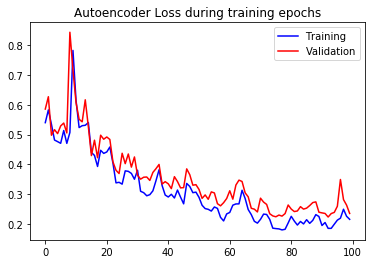

0.2152251326597315


In [13]:
## TRAINING
# Fit the training data into the autoencoder.
history = autoencoder.fit(X_train_norm,X_train_norm,
                          validation_data=(X_test_norm,X_test_norm),
                          epochs=100,
                          verbose=1,
                          callbacks=[])
# Plot training vs validation losses
plt.plot(history.history["loss"], c = 'b', label = "Training")
plt.plot(history.history["val_loss"], c = 'r', label = "Validation")
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.show()
print(history.history["loss"][-1])

# Encode datasets using the trained encoder.
X_train_encoded = encoder.predict(X_train_norm)
X_test_encoded = encoder.predict(X_test_norm)

# Renormalize data
scaler = MinMaxScaler()
X_train_encoded = pd.DataFrame(scaler.fit_transform(X_train_encoded))
X_test_encoded = pd.DataFrame(scaler.fit_transform(X_test_encoded))

# Next we will use this datasets to evaluate and compare with the latent representation obtained with the autoencoder:
# Original dataset: "X_train_norm" a 433x20502 Matrix.
# Encoded dataset: "X_train_encoded" a 433x{encoded_dim} Matrix. 

In [22]:
### CLASSIFICATION ###
# We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.

# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

## Definition of the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(dropout: int, l1: int, l2: int, input_shape: int):
    model = keras.Sequential([
        layers.Dense(2000, activation=tf.nn.relu ,kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=(input_shape,)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(200,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(20,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(2,activation=tf.nn.softmax)
      ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model


# Fit best model with dimensionality reduction data
model_ae = build_best_model(0.5,0.0001, 0.0001, X_train_encoded.shape[1])
history_ae = model_ae.fit(X_train_encoded, y_train_oh, epochs=300,
                    validation_split = 0.05, verbose=1, callbacks=[], shuffle=False)
hist_ae = pd.DataFrame(history_ae.history)

test_loss, test_acc = model_ae.evaluate(X_test_encoded, y_test_oh)

# Fit best model with concatenated data
#model = build_best_model(0.5,0.0001,0.0001, X_train_norm.shape[1])
#history = model.fit(X_train, y_train_oh, epochs=150,
#                    validation_split = 0.1, verbose=1, callbacks=[early_stop])
#hist = pd.DataFrame(history.history)

#test_loss, test_acc = model.evaluate(X_test, y_test_oh)

Train on 411 samples, validate on 22 samples
Epoch 1/300
411/411 [==============================] - 1s 3ms/sample - loss: 2.2368 - accuracy: 0.5061 - val_loss: 1.8269 - val_accuracy: 0.5455
Epoch 2/300
411/411 [==============================] - 0s 548us/sample - loss: 2.1704 - accuracy: 0.4891 - val_loss: 1.7179 - val_accuracy: 0.5455
Epoch 3/300
411/411 [==============================] - 0s 544us/sample - loss: 1.9214 - accuracy: 0.5742 - val_loss: 1.6766 - val_accuracy: 0.5455
Epoch 4/300
411/411 [==============================] - 0s 546us/sample - loss: 1.9336 - accuracy: 0.5353 - val_loss: 1.6373 - val_accuracy: 0.5455
Epoch 5/300
411/411 [==============================] - 0s 517us/sample - loss: 1.7853 - accuracy: 0.5839 - val_loss: 1.6018 - val_accuracy: 0.6364
Epoch 6/300
411/411 [==============================] - 0s 587us/sample - loss: 1.7266 - accuracy: 0.6010 - val_loss: 1.5710 - val_accuracy: 0.7273
Epoch 7/300
411/411 [==============================] - 0s 757us/sample - lo

In [ ]:
###### CLUSTERING ###
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
ae_cluster_labels = kmeans.fit_predict(X_train_encoded)
ae_silhouette_avg = silhouette_score(X_train_ae, ae_cluster_labels)

cluster_labels = kmeans.fit_predict(X_train)
silhouette_avg = silhouette_score(X_train, cluster_labels)

print(f"AE silhoutte score: {ae_silhouette_avg}")
print(f"Original silhoutte score: {silhouette_avg}")

### PLOT SILOHUETTE SCORE FOR CLUSTERS
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X_train_ae) + (n_clusters + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train_ae, ae_cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=ae_silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax2.set_title("The silhouette plot for the various clusters.")
ax2.set_xlabel("The silhouette coefficient values")
ax2.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")

ax2.set_yticks([])  # Clear the yaxis labels / ticks
ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [2]:
X_train_norm.shape

(433, 20502)

In [3]:
X_train_encoded.shape

NameError: name 'X_train_encoded' is not defined